In [3]:
import numpy as np

import pandas as pd
import xarray as xr
import glob

from importlib import reload

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

import cartopy.io.shapereader as shapereader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER






Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
import preseason.tools as sf
import preseason.onset_demise as od

In [ ]:
def debug_interp(xi, x, data):
    print(f"data: {data.shape} | x: {x.shape} | xi: {xi.shape}")
    return np(xi, x, data)

In [61]:
reload(od)
reload(sf)

<module 'preseason.tools' from '/Users/gbromley/code/PreSeason/preseason/tools.py'>

In [5]:
### Peru Domain ###
#min_lon = -83+360
#min_lat = -20.0
#max_lon = -67+360
#max_lat = 0.0



### processing CPC data 


cpc_files = glob.glob('/Users/gbromley/data/cpc_uni_global/precip.*.nc')
cpc_raw = xr.open_mfdataset(cpc_files)

### Setting coordinate data for next step 
lat = np.arange(-90, 90, 0.5)
lon = np.arange(0, 360, 0.5)
time = cpc_raw['time'].data

### transposing dimensions so the world is right side up 

flipped_cpc = np.flip(cpc_raw['precip'].values, axis=1)
### cpc latitudes are reversed so that they are decreasing instead of increasing. The following code reverses it. 
cpc_pr = xr.DataArray(flipped_cpc, coords=[('time', time), ('lat', lat), ('lon', lon)], name='precipitation')

#TODO create xml of location definitions
### Selecting out Peru from the global data.
PERU = {'lat': slice(-20,0), 'lon': slice(360-83, 360-67)}
cpc_conus = cpc_pr.sel(lat = PERU['lat'], lon = PERU['lon'])

In [7]:
bom_files = glob.glob('/Users/gbromley/data/b17_cpc_onset-demise/onset.wet.season.CPC_UNI.*.nc')
test_bombardi = xr.open_mfdataset(sorted(bom_files), decode_cf = False, combine = 'nested', concat_dim='time')
test_bombardi = test_bombardi['DOY'].sel(PERU).squeeze()
test_bombardi = xr.where(test_bombardi == -999., np.nan, test_bombardi)

pd.date_range('1979', freq='YS', periods = 42)
test_bombardi['time'] = pd.date_range('1979', freq='YS', periods = 42)

In [65]:
cpc_conus_anom = cpc_conus - cpc_conus.mean(dim='time')

annual_cycle = sf.calc_annual_cycle(cpc_conus)
start_wet = od.B17_analysis_start(annual_cycle)

In [15]:
onset = od.onset_B17(cpc_conus_anom, startWet=start_wet)

In [63]:
demise = od.demise_B17(cpc_conus_anom, startWet=start_wet)

In [55]:
reload(od)
reload(sf)
time_slice = slice(2000,3000)
test_loc = 20
temp = cpc_conus_anom.isel(lat=test_loc, lon=test_loc, time=time_slice)
temp_start = start_wet.isel(lat=test_loc, lon=test_loc)


test_data = od._onset_B17(temp.values, time=temp.time.values,startWet=temp_start.values)
test_demise = od._demise_B17(temp.values, time=temp.time.values,startWet=temp_start.values)

In [ ]:
reload(od)
reload(sf)
time_slice = slice(1000,6000)
test_loc = 20
temp = cpc_conus_anom.isel(lat=test_loc, lon=test_loc, time=time_slice)
temp_start = start_wet.isel(lat=test_loc, lon=test_loc)


#test_data = od._onset_B17(temp.values, time=temp.time.values,startWet=temp_start.values)
#test_demise = od._demise_B17(temp.values, time=temp.time.values,startWet=temp_start.values)

data = temp.values
startWet = temp_start.values
time = temp.time.values

time = pd.to_datetime(time)
years = np.array(time.year)
days = np.array(time.dayofyear)


#TODO These tests can move to data 
if len(days) != len(years):
    raise ValueError('Length of days and years must be the same.')
    
# Want to make sure we get all the input years before any trimming
unique_years = np.unique(years)

doy_b17 = np.empty(len(unique_years))
doy_b17[:] = np.nan

if np.all(np.isnan(data)):
    print("Error")

onsetDOY = od._onset_LM01(data, time, startWet)

if np.all(onsetDOY == onsetDOY[0]):
    
    print("error")


# Day of year is missing integer 60 which is February 29th. 
# Need to add zero because a tuple is returned from np.where
print(onsetDOY)
outliers = sf.check_outliers(onsetDOY)


if np.any(outliers):
    
    onsetDOY[outliers] = np.nan

#TODO Days and startwet are off by one
start_day_index = np.where(days == startWet+1)[0]

### looping through start dates ###
for start_day in start_day_index:
    print(start_day)
    # Period over which we take the cumulative sum
    analysis_begin = start_day
    analysis_end = start_day + 365
    
    # Handle if it's the last chunk of data
    if (analysis_end > len(data)):
        analysis_end = len(data)
    
    analysis_days = days[analysis_begin:analysis_end]
    analysis_years = years[analysis_begin:analysis_end] 
    
    cumsum_data = sf.cumul_anom(data, analysis_begin, analysis_end)
    # this returns the index of the data not the day
    #onset_index = np.argmin(cumsum_data)
    #onset_day = analysis_days[onset_index]
    #onset_year = analysis_years[onset_index]
    #if analysis_end == len(data):
    #     extend = cumsum_data[::-1]
    #    extend = 
        
    print(analysis_begin)
    smoothed_cs_data = sf.smooth_B17(cumsum_data)
    plt.plot(smoothed_cs_data)
    onset_index = sf.find_ddt_onset(smoothed_cs_data)
    print(onset_index)
    
    
    # this returns the index of the data not the day
    #TODO Clean up saving the data so it's less funky
    if np.isnan(onset_index):
        continue
        
    onset_day = analysis_days[onset_index]
    onset_year = analysis_years[onset_index]
    
    
    where_to_place = np.argwhere(unique_years == onset_year)[0][0]
    
    doy_b17[where_to_place] = onset_day
        
    
    
    

onsetDOY = doy_b17

outliers_3 = sf.check_outliers(onsetDOY, threshold=3.)
if np.any(outliers_3):
    
    onsetDOY[outliers_3] = np.nan


In [ ]:
onsetDOY

In [ ]:
pre_color = '#30638E'
anom_line = plt.plot(temp.time, temp, pre_color, label=r'P$_{anom}$', alpha=0.8) 

In [ ]:
cumul = np.cumsum(temp.values, axis=0)
filtered_cumul = sf.smoothing_harmonic(cumul, num_harm=20)

In [ ]:
np.unique(data.time.dt.year)

In [ ]:
time_out = np.unique(temp.time.dt.year)
output = xr.apply_ufunc(
    od._onset_LM01,
    temp,
    temp.time,
    temp_start,
    input_core_dims=[["time"],["time"],[]],
    exclude_dims=set(["time"]),
    output_core_dims=[["year"]],
    vectorize= True,
    dask = 'parallelized'
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
    )
output['year'] = pd.date_range(time_out[0], freq='YS', periods = len(time_out))



In [76]:
onset

<xarray.DataArray (lat: 41, lon: 33, year: 33)>
array([[[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [311., 240., 213., ..., 261., 235., 315.],
        [306., 240., 212., ..., 264., 238., 317.],
        [303., 237., 210., ..., 310., 279., 319.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [311., 240., 240., ..., 262., 235., 339.],
        [311., 240., 214., ..., 263., 236., 338.],
        [337., 240., 212., ..., 265., 239., 333.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
...
        ...,
        [336., 313., 351., ..., 286., 292., 279.],
        [342., 291.,  nan, ..., 287., 290., 278.],
        [348., 289., 334., ..., 287., 289., 330.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [285.,  nan, 303., ..., 313., 293., 330.],
        [336., 358., 351., ..., 285., 292., 330.],
        [341., 354.,  nan, ..., 312., 291., 309.]],

       [[ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        [ nan,  nan,  nan, ...,  nan,  nan,  nan],
        ...,
        [332.,  nan, 299., ..., 313., 292., 330.],
        [337., 357., 347., ..., 313., 319., 330.],
        [341., 353.,  nan, ..., 313., 319., 330.]]])
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... -1.5 -1.0 -0.5 0.0
  * lon      (lon) float64 277.0 277.5 278.0 278.5 ... 291.5 292.0 292.5 293.0
  * year     (year) datetime64[ns] 1979-01-01 1980-01-01 ... 2011-01-01

In [50]:
bom_vals = test_bombardi.isel(lat=20, lon=20)

In [67]:
onset_single = onset.isel(lat=20, lon=20)
demise_single = demise.isel(lat=20, lon=20)

In [39]:
pd.to_datetime(np.unique(temp.time.dt.year), format="%Y")

DatetimeIndex(['1979-01-01', '1980-01-01'], dtype='datetime64[ns]', freq=None)

In [14]:
onset

NameError: name 'onset' is not defined

In [11]:
itest = (20,20)

In [67]:
min(cpc_conus_anom)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

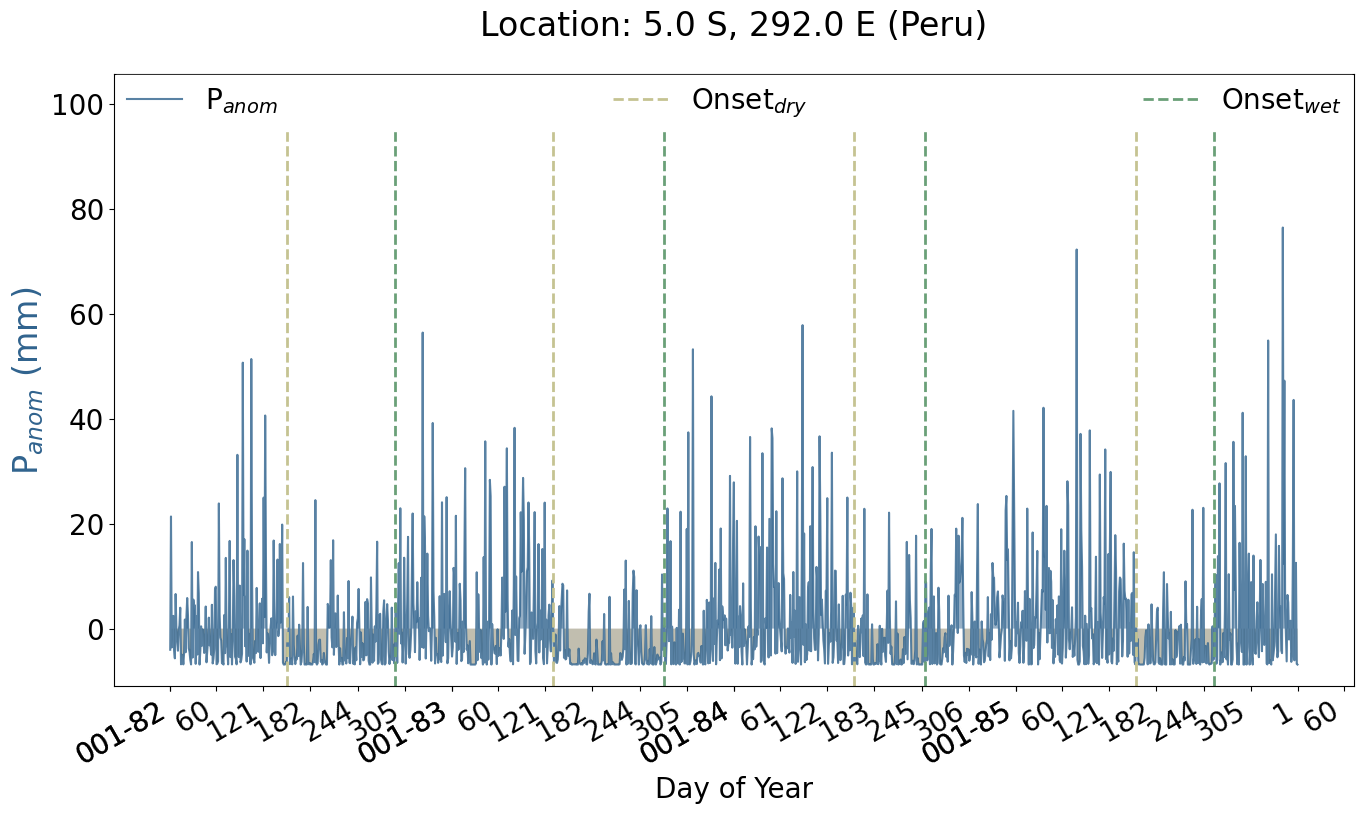

In [89]:
plotOnsetTS(cpc_conus_anom, onset, demise, slice('1982', '1985'), iloc=(30,30))

In [88]:
def plotOnsetTS(p_anom, onset_data, demise_data, time_slice, loc = None, iloc = None):
    ### Take precip data, calculated onsets, make a nice TS figure
    #TODO error handle on the other arguments
    ### Argument Handling ###
    if (loc is None and iloc is None) or (loc is not None and iloc is not None):
        raise ValueError("Exactly one location argument must be provided.")
    
    
    if (loc is not None):
        lat = loc[0]
        lon = loc[1]
        
    if (iloc is not None):
        lat = p_anom.lat[iloc[0]]
        lon = p_anom.lon[iloc[1]]
    
    
    ### Data Wrangling ###
    
    
    
    p_anom_ts = p_anom.sel(time=time_slice, lat=lat, lon=lon)
    
    time = p_anom_ts.time.values
    year_array = pd.to_datetime(np.unique(p_anom_ts.time.dt.year), format="%Y")
    
    onset_ts = onset_data.sel(year=time_slice, lat=lat, lon=lon)
    demise_ts = demise_data.sel(year=time_slice, lat=lat, lon=lon)
    

    
    ### Onset/Demise plotting section ###
    
    # create empty array to hold dates
    onset_dates = np.empty_like(onset_ts, dtype=np.dtype('M8[D]'))
    onset_dates[:] = np.datetime64("NaT")

    demise_dates = np.empty_like(demise_ts, dtype=np.dtype('M8[D]'))
    demise_dates[:] = np.datetime64("NaT")

    # convert onset days to labels
    for i,j in enumerate(onset_ts.values):
        
        if not np.isnan(j):
            
            onset_dates[i] = year_array[i] + pd.Timedelta(int(j), unit='day')
            
    for i,j in enumerate(demise_ts.values):
        if not np.isnan(j):
            
            demise_dates[i] = year_array[i] + pd.Timedelta(int(j), unit='day')

    ticks_str = year_array

    ticks_to_add = [int(mdates.date2num(item)) for item in ticks_str]
    
    additional_labels = [mdates.num2date(year).strftime('%j-%y') for year in ticks_to_add]

    
    
    ### Plotting Parameters ###
    plt.rcParams['font.size'] = 20
    fs = plt.rcParams['font.size']
    pre_color = '#30638E'
    cumul_color = '#193C16'
    
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()
    fig.set_size_inches((16,9))
    
    # Plot the first data set with the first y-axis
    anom_line = ax1.plot(time, p_anom_ts, pre_color, label=r'P$_{anom}$', alpha=0.8)  # 'g-' is for green solid line
    
    ax1.set_xlabel('Day of Year')
    ax1.set_ylabel(r'P$_{anom}$ (mm)', color=pre_color, fontsize=fs+4)  # Set the color of the y-axis label to green
    ax1.tick_params(axis='y', labelcolor='black')
    
    ymin, ymax = plt.ylim()
    ax1.set_ylim(ymin,ymax+25)
    
    # Color in the area above and below zero
    ax1.fill_between(time, p_anom_ts, 0, alpha=0.5, where= p_anom_ts > 0, facecolor = '#30638E')
    ax1.fill_between(time, p_anom_ts, 0, alpha=0.5, where= p_anom_ts < 0, facecolor='#857E61')


    for i in onset_dates:
        if not np.isnan(i):
            onset_line = plt.axvline(x=i, ymin=0, ymax=1, color='#6AA078', linewidth=2, linestyle='--')

    for j in demise_dates:
        if not np.isnan(j):
            
            demise_line = plt.axvline(x=j, ymin=0, ymax=1, color='#C5C392', linewidth=2, linestyle='--')
    

    onset_line.set_label(r'Onset$_{ wet}$')
    demise_line.set_label(r'Onset$_{ dry}$')
    
        
    # make the ticks look pretty
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    current_ticks = plt.gca().get_xticks()[1:]
    current_labels = [mdates.num2date(tick).strftime('%-j') for tick in current_ticks]
    
    # Combine current and additional ticks and labels
    all_ticks = np.concatenate((current_ticks, ticks_to_add))
    all_labels = current_labels + additional_labels
    
    plt.gca().set_xticks(all_ticks)
    plt.gca().set_xticklabels(all_labels)
    plt.gcf().autofmt_xdate(rotation=30)
    
    # adjust the legend
    legend_artists = [anom_line[0], demise_line, onset_line]
    legend_labels = [r'P$_{anom}$', r'Onset$_{ dry}$', r'Onset$_{ wet}$']
    fig.legend(legend_artists, legend_labels, loc='lower left', bbox_to_anchor=(.1175, 0.802, 0.79, .25), ncols=3, mode='expand', frameon=True, fancybox=False, framealpha=1, edgecolor='white')

    # set title to lat/lon
    ax1.set_title('Location: '+str(np.abs(lat.values))+' S, '+str(lon.values)+' E'+' (Peru)', x=0.5, y=1.05)



    #out_path = '/Users/gbromley/Dropbox/OU/Peru/'
    #plt.savefig(out_path+'Peru_Example.png', dpi=600, transparent=True)
    plt.show()
    
    return None
    

0 235.0
[6940, 7305]


/var/folders/m4/3slgbrxj3z3dm65l82539j6w0000gq/T/ipykernel_31518/2128234686.py:119: UserWarning: Legend does not support handles for float32 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  fig.legend(legend_artists, legend_labels, loc='lower left', bbox_to_anchor=(.1175, 0.81, 0.79, .25), ncols=4, mode='expand', frameon=True)


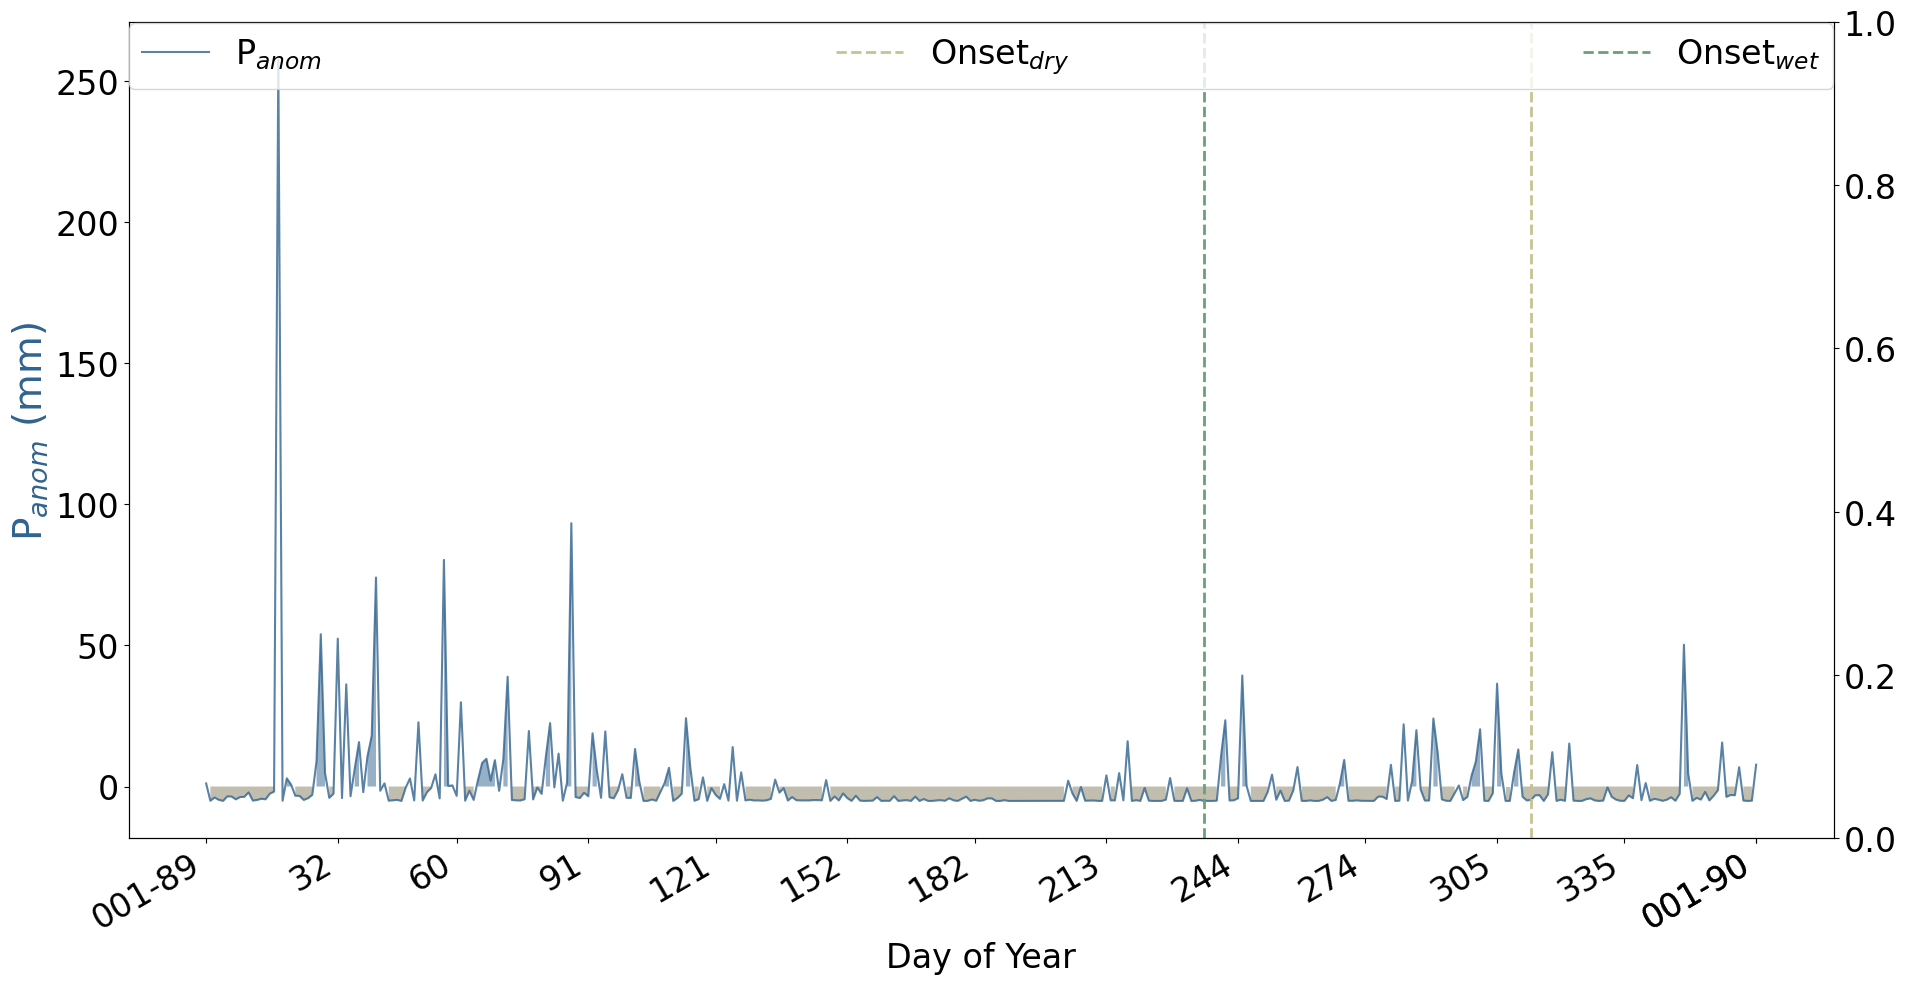

In [79]:
import matplotlib.dates as mdates
import datetime
from matplotlib.legend_handler import HandlerLine2D



reload(od)
reload(sf)
time_slice = slice('1989-01-01','1990-01-01')
test_loc = 20
temp = cpc_conus_anom.sel(time=time_slice).isel(lat=test_loc, lon=test_loc)
temp_start = start_wet.isel(lat=test_loc, lon=test_loc)


years = pd.to_datetime(np.unique(temp.time.dt.year), format="%Y")

num_years = len(years)

#TODO Need to adjust this interval to match data.
bom_onsets = bom_vals.sel(time=years[:-1]).values
onset_doy = onset_single.sel(year=years[:-1]).values
demise_doy = bom_onsets #demise_single.sel(year=years[:-1]).values

pre_color = '#30638E'
#
# '#3FA7D6'
#
cumul_color = '#193C16'
#'#F18F01'
#'#0D1431'
plt.rcParams['font.size'] = 24

fs = plt.rcParams['font.size']
#orange = F18F01
# Create a figure and a set of subplots
fig, ax1 = plt.subplots()
fig.set_size_inches((22,12))
# Plot the first data set with the first y-axis
anom_line = ax1.plot(temp.time, temp, pre_color, label=r'P$_{anom}$', alpha=0.8)  # 'g-' is for green solid line
ax1.set_xlabel('Day of Year')
ax1.set_ylabel(r'P$_{anom}$ (mm)', color=pre_color, fontsize=fs+4)  # Set the color of the y-axis label to green
ax1.tick_params(axis='y', labelcolor='black')

#ax1.set_ylim(-7,25)

#ax1.set_xlim(7300,7750)

ax1.fill_between(temp.time, temp, 0, alpha=0.5, where=temp > 0, facecolor = '#30638E')
ax1.fill_between(temp.time, temp, 0, alpha=0.5, where=temp < 0, facecolor='#857E61')

# Create a second y-axis that shares the same x-axis
#ax2 = ax1.twinx()  
#cumul = ax2.plot(temp.time, filtered_cumul, cumul_color, label=r'Cumul. $P_{anom}$', linewidth=3, alpha = 0.9)  # 'b-' is for blue solid line
#ax2.set_ylabel(r'Accumulated P$_{anom}$ (mm)', color=cumul_color, fontsize=fs+4)  # Set the color of the y-axis label to blue
#ax2.tick_params(axis='y', labelcolor='black')

#ax2.set_ylim(-200, 800)
# Format date
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%j'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

current_ticks = plt.gca().get_xticks()[1:]
current_labels = [mdates.num2date(tick).strftime('%-j') for tick in current_ticks]

#annotated ticks




onset_dates = np.empty_like(onset_doy, dtype=np.dtype('M8[D]'))
onset_dates[:] = np.datetime64("NaT")

demise_dates = np.empty_like(demise_doy, dtype=np.dtype('M8[D]'))
demise_dates[:] = np.datetime64("NaT")


for i,j in enumerate(onset_doy):
    print(i, j)
    if not np.isnan(j):
        
        onset_dates[i] = years[i] + pd.Timedelta(int(j), unit='day')
        
for i,j in enumerate(demise_doy):
    if not np.isnan(j):
        
        demise_dates[i] = years[i] + pd.Timedelta(int(j), unit='day')

ticks_str = years

ticks_to_add = [int(mdates.date2num(item)) for item in ticks_str]
print(ticks_to_add)

#TODO clean all odf this up.
additional_labels = [mdates.num2date(year).strftime('%j-%y') for year in ticks_to_add]

# Combine current and additional ticks and labels
all_ticks = np.concatenate((current_ticks, ticks_to_add))
all_labels = current_labels + additional_labels

#ymin, ymax = plt.ylim()
#ax1.vlines(temp.time.values[result], ymin, ymax)

for i in onset_dates:
    if not np.isnan(i):
        onset_line = plt.axvline(x=i, ymin=0, ymax=1, color='#6AA078', linewidth=2, linestyle='--')

for j in demise_dates:
    if not np.isnan(j):
        
        demise_line = plt.axvline(x=j, ymin=0, ymax=1, color='#C5C392', linewidth=2, linestyle='--')


onset_line.set_label(r'Onset$_{ wet}$')
demise_line.set_label(r'Onset$_{ dry}$')
# Rotate date labels

legend_artists = [anom_line[0], demise_line, onset_line, cumul[0]]
legend_labels = [r'P$_{anom}$', r'Onset$_{ dry}$', r'Onset$_{ wet}$',r'Cumul. $P_{anom}$']
fig.legend(legend_artists, legend_labels, loc='lower left', bbox_to_anchor=(.1175, 0.81, 0.79, .25), ncols=4, mode='expand', frameon=True)

#ax1.set_title('Location: '+str(np.abs(temp.lat.values))+' S, '+str(temp.lon.values)+' W'+' (Peru)', x=0.5, y=1.05)

#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.gca().set_xticks(all_ticks)
plt.gca().set_xticklabels(all_labels)
plt.gcf().autofmt_xdate(rotation=30)


# Set the combined ticks and labels

#plt.plot(temp.time, filtered_cumul)
#(temp*10).plot()
out_path = '/Users/gbromley/Dropbox/OU/Peru/'
plt.savefig(out_path+'Peru_Example.png', dpi=600, transparent=True)
plt.show()

In [44]:
onset_doy

array([255.,  nan])

In [ ]:


map_proj = ccrs.Orthographic(central_longitude = -75, central_latitude= -10)



fig, ax = plt.subplots(1, 1, figsize=(10, 13), dpi=600,  subplot_kw={'projection': map_proj})

ax.pcolormesh(cpc_conus.isel(time=100).values, alpha=0.5, transform=ccrs.PlateCarree())

ax.set_global()

ax.plot(285,-10,'bo', markersize=7)


In [ ]:
reload(od)
reload(sf)
bom_demise = od.demise_B17(cpc_conus_anom,start_wet)
bom_onset = od.onset_B17(cpc_conus_anom,start_wet)


In [ ]:
import matplotlib.ticker as mticker


from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def plot_spatial_data(dataarray, projection=ccrs.PlateCarree(), title='Spatial Data Plot', var='data_to_plot'):
    """
    Plots a spatial figure of a variable from an xarray DataArray.

    :param dataarray: xarray DataArray containing the geospatial data to be plotted.
    :param projection: Cartopy CRS projection. Defaults to PlateCarree.
    :param title: Title of the plot.
    """
    
    states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m')
    map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
    #cmap = mpl.cm.RdBu_r


    fig, ax = plt.subplots(1, 1, figsize=(10, 13), dpi=600,  subplot_kw={'projection': projection})
    p = dataarray.plot(ax=ax,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='twilight',alpha = 0.8)


    ### Setting 1st plot parameters ###
    ax.coastlines(edgecolor='black', linewidth=2)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=2)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
    ax.add_feature(cfeature.LAKES, alpha=0.5, edgecolor='blue')
    ax.add_feature(cfeature.RIVERS, color='blue')
    #ax1.set_xticks(np.arange(-180,181, 40))
    #ax1.set_yticks(np.arange(-90,91,15))
    drainage = shapereader.Reader('/Users/gbromley/Downloads/major_basins_of_the_world_0_0_0/Major_Basins_of_the_World.shp')
    #for feature in drainage.records():
    #    geometry = feature.geometry
    #    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2, linestyle='--')
    #at = AnchoredText("a",
    #                    loc='upper left', prop=dict(size=8), frameon=True,)
    #at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    #ax1.add_artist(at)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    plt.colorbar(p, cax=cax, label=var)
    
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=2, color='black', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator([280-360, 285-360, 290-360])
    gl.ylocator = mticker.FixedLocator([-5, -10, -15])
    gl.left_labels = True
    gl.right_labels = False
    gl.top_labels = False
    gl.bottom_labels = True

    # Add a title
    ax.set_title(title, loc='center')

    # Show the plot
    plt.show()

In [ ]:
peru_shp = '/Users/gbromley/Library/CloudStorage/Dropbox/Mac (2)/Downloads/per_adm_ign_20200714_shp'
import xarray as xr
import geopandas as gpd
import rioxarray
# Load climate dataset
climate_data = xr.open_dataarray('onset_LM01_peru.nc').isel(year=1)

# Load vector data
peru_outline = gpd.read_file(peru_shp)

# Set spatial coordinates and reproject if needed
climate_data = climate_data.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
climate_data = climate_data.rio.write_crs('EPSG:4326')

# Clip climate dataset to Peru's extent
clipped_data = climate_data.rio.clip(peru_outline.geometry, peru_outline.crs)

# Create mask based on Peru's outline
mask = clipped_data.rio.geometry_mask(peru_outline.geometry, peru_outline.crs)

# Apply mask to the clipped dataset
masked_data = clipped_data.where(mask)

# Save masked dataset to a new file
masked_data

In [ ]:
peru_outline.crs

In [ ]:
import geopandas
import rioxarray
import xarray
from shapely.geometry import mapping


MSWEP_monthly2 = xarray.open_dataarray('D:\G3P\DATA\Models\MSWEP\MSWEP_monthly.nc4')
MSWEP_monthly2.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
MSWEP_monthly2.rio.write_crs("epsg:4326", inplace=True)
Africa_Shape = geopandas.read_file('D:\G3P\DATA\Shapefile\Africa_SHP\Africa.shp', crs="epsg:4326")

clipped = MSWEP_monthly2.rio.clip(Africa_Shape.geometry.apply(mapping), Africa_Shape.crs, drop=False)